# Bibliotecas

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
#basics
import sys,os
sys.path.insert(1, os.path.dirname(os.getcwd()))

#utils
import paths

#main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.precision", 4)
%matplotlib inline

#model Libraries
from sklearn import utils
from sklearn import preprocessing

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

#Light GBM
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from lightgbm import LGBMRanker

In [13]:
#private modules 
#data
from src.data import make_dataset

#utils
from src.utils import memory_usage

#models
from src.models import train_model
from src.models import evaluation

#validation
from src.validation import metrics
from src.validation import metrics_description

In [14]:
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor

from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from lightgbm import LGBMRanker

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import XGBRanker

# Dados

In [15]:
%%time
df_training,features,target = make_dataset.get_data(nrows=5000,
                                                    low_memory=False, 
                                                    dataset="training", 
                                                    feather=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 314 entries, id to target_kazutsugi
dtypes: float32(311), int32(1), object(2)
memory usage: 6.0+ MB
None
CPU times: user 960 ms, sys: 3.55 s, total: 4.51 s
Wall time: 5.48 s


In [47]:
%%time
df_validation,features,target = make_dataset.get_data(nrows=None,
                                                    low_memory=False, 
                                                    dataset="validation", 
                                                    feather=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106895 entries, 0 to 106894
Columns: 314 entries, id to target_kazutsugi
dtypes: float32(311), int32(1), object(2)
memory usage: 128.9+ MB
None
CPU times: user 534 ms, sys: 847 ms, total: 1.38 s
Wall time: 975 ms


In [16]:
print(memory_usage.memory())

Available memory (%): 26.99270248413086
None


# Setup

In [17]:
# The models should be scored based on the rank-correlation (spearman) with the target
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

# Modelos

In [18]:
model_name = [
               "XGBClassifier"
              ,"XGBRegressor"
              ,"XGBRanker"
              ,"LGBMClassifier"
              ,"LGBMRegressor"
              ,"LGBMRanker"
              ,"CatBoostClassifier"
              ,"CatBoostRegressor"              
]

In [19]:
est = 2000
models = [
    XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=est, n_jobs=-1, colsample_bytree=0.1, tree_method='gpu_hist', gpu_id=0),
    XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=est, n_jobs=-1, colsample_bytree=0.1, tree_method='gpu_hist', gpu_id=0),
    XGBRanker(max_depth=5, learning_rate=0.01, n_estimators=est, n_jobs=-1, colsample_bytree=0.1, tree_method='gpu_hist', gpu_id=0)
] +  [
    LGBMClassifier(max_depth=5, learning_rate=0.01, n_estimators=est, n_jobs=-1, colsample_bytree=0.1, num_leaves=32, device_type = "gpu"),
    LGBMRegressor(max_depth=5, learning_rate=0.01, n_estimators=est, n_jobs=-1, colsample_bytree=0.1, num_leaves=32, device_type = "gpu"),
    LGBMRanker(max_depth=5, learning_rate=0.01, n_estimators=est, n_jobs=-1, colsample_bytree=0.1, num_leaves=32, device_type = "gpu")
] +  [
    CatBoostClassifier(max_depth=5, learning_rate=0.01, n_estimators=est, task_type='GPU'),
    CatBoostRegressor(max_depth=5, learning_rate=0.01, n_estimators=est, task_type='GPU')
]

In [ ]:
#NAO RODE

results = dict()
from time import time

for i,model in enumerate(models):
    model_res = dict()
    print(" -- ", model)
    start = time()
    if model_name[i] == "XGBRanker" or model_name[i] == "LGBMRanker":
        model.fit(df1[features], df1[target], group=group)
    else:
        model.fit(df1[features], df1[target])
    elapsed = time() - start
    model_res["outsample"] = numerai_score(df2[target], pd.Series(model.predict(df2[features]).reshape(1,-1)[0], index=df2.index))
    model_res["insample"] = numerai_score(df1[target], pd.Series(model.predict(df1[features]).reshape(1,-1)[0], index=df1.index))
    model_res["time_elapsed(s)"] = elapsed
    results[model_name[i]] = model_res
    #dump(model, 'models/baseline_'+ model_name[i] +'.pkl')

res = pd.DataFrame.from_dict(results).T
pd.set_option("display.precision", 4)

#final_results = res.sort_values(by=['outsample'], ascending=False)
#final_results.to_csv("results_baseline_sem_gpu.csv", index=True)

### Carregando Modelos treinados

In [21]:
from joblib import  load
models = dict()

for model in model_name:   
    file_path = '../../models/baseline/baseline_'+model+'.pkl'
    models[model] = load(file_path)

[12:53:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [35]:
results = pd.read_csv("../../reports/results_baseline.csv")

results.sort_values(by=['outsample'], ascending=False)

,outsample,insample,time_elapsed_GPU(s),time_elapsed(s)
LGBMRegressor,0.0447,0.2677,23.8324,62.3275
XGBRanker,0.0442,0.2021,67.5707,469.0444
XGBRegressor,0.0440,0.2667,37.2466,445.6100
LGBMClassifier,0.0305,0.2070,137.1966,301.8254
XGBClassifier,0.0302,0.1648,232.9470,2172.2911
CatBoostClassifier,0.0271,0.0959,19.0138,1193.6433
CatBoostRegressor,0.0267,0.0949,9.2403,209.8839
LGBMRanker,0.0150,0.0647,6092.7200,16133.8554


#### Metricas Classificacao 

In [23]:
preds = models["LGBMClassifier"].predict(df_validation[features])

              precision    recall  f1-score   support

           0       0.27      0.28      0.28     21352
           1       0.23      0.15      0.18     21363
           2       0.27      0.36      0.31     21474
           3       0.22      0.15      0.18     21362
           4       0.27      0.35      0.30     21344

    accuracy                           0.26    106895
   macro avg       0.25      0.26      0.25    106895
weighted avg       0.25      0.26      0.25    106895



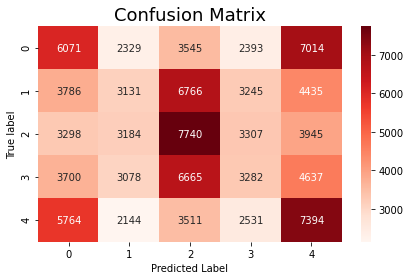

In [120]:
evaluation.plot_confusion_matrix(lab_enc.fit_transform(df_validation[target]), preds/4)

array([[ 1.        , -0.81393351, -0.8942065 , -0.88654085,  0.78328667],
       [-0.81393351,  1.        ,  0.80874765,  0.72378902, -0.89877694],
       [-0.8942065 ,  0.80874765,  1.        ,  0.77462933, -0.90867348],
       [-0.88654085,  0.72378902,  0.77462933,  1.        , -0.80042416],
       [ 0.78328667, -0.89877694, -0.90867348, -0.80042416,  1.        ]])

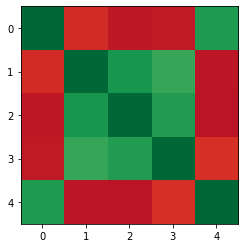

In [121]:
# The first and last class are highly correlated
corrs=np.corrcoef(model.predict_proba(df_validation[features]).T)
plt.imshow(corrs, vmin=-1, vmax=1, cmap="RdYlGn")
corrs

### Neutralize

In [37]:
preds = models["LGBMRegressor"].predict(df_validation[features])

In [199]:
from sklearn.preprocessing import MinMaxScaler
import scipy
def _neutralize(df, columns, by, proportion=1.0):
    scores = df[columns]
    exposures = df[by].values
    scores = scores - proportion * exposures.dot(np.linalg.pinv(exposures).dot(scores))
    return scores / scores.std()

def _normalize(df):
    X = (df.rank(method="first") - 0.5) / len(df)
    return scipy.stats.norm.ppf(X)

def normalize_and_neutralize(df, columns, by, proportion=1.0):
    # Convert the scores to a normal distribution
    df[columns] = _normalize(df[columns])
    df[columns] = _neutralize(df, columns, by, proportion)
    return df[columns]


In [215]:
df_validation["preds"] = preds /16


df_validation["preds_neutralized"] = df_validation.groupby("era").apply(
    lambda x: normalize_and_neutralize(x, ["preds"], features, .50) # neutralize by 50% within each era
)
scaler = MinMaxScaler()
df_validation["preds_neutralized"] = scaler.fit_transform(df_validation[["preds_neutralized"]]) # transform back to 0-1

In [216]:
df_validation["preds_neutralized"].describe()

count    106895.0000
mean          0.5009
std           0.1242
min           0.0000
25%           0.4171
50%           0.5009
75%           0.5843
max           1.0000
Name: preds_neutralized, dtype: float64

### Testando corr pelo tempo

In [258]:
preds = models["LGBMRegressor"].predict(df_training[features])

In [264]:
df_training["preds"] = preds /16


df_training["preds_neutralized"] = df_training.groupby("era").apply(
    lambda x: normalize_and_neutralize(x, ["preds"], features, .5) # neutralize by 50% within each era
)
scaler = MinMaxScaler()
df_training["preds_neutralized"] = scaler.fit_transform(df_training[["preds_neutralized"]]) # transform back to 0-1

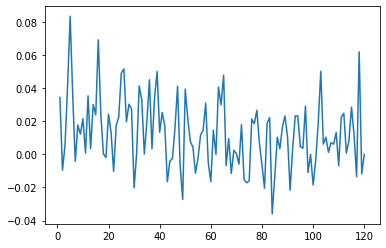

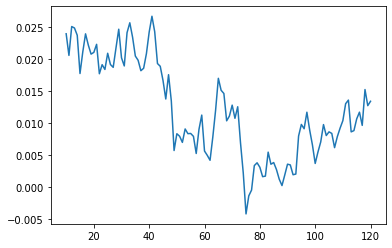

In [260]:
# Single features do not work consistently though
by_era_correlation = pd.Series({
    era: np.corrcoef(tdf[target], tdf["feature_strength34"])[0,1]
    for era, tdf in df_training.groupby("era")
})
by_era_correlation.plot()
plt.show()
by_era_correlation.rolling(10).mean().plot()

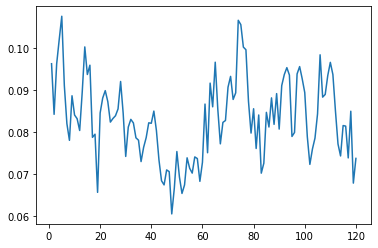

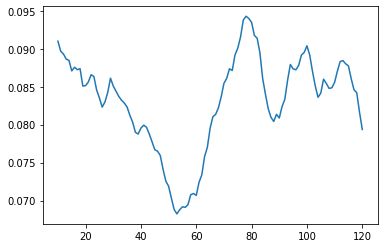

In [263]:
# Single features do not work consistently though
by_era_correlation = pd.Series({
    era: np.corrcoef(tdf["preds_neutralized"], tdf["feature_strength34"])[0,1]
    for era, tdf in df_training.groupby("era")
})
by_era_correlation.plot()
plt.show()
by_era_correlation.rolling(10).mean().plot()

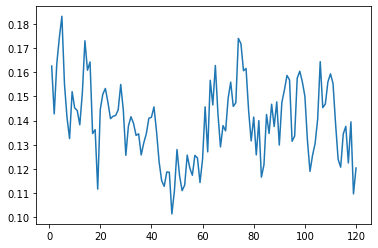

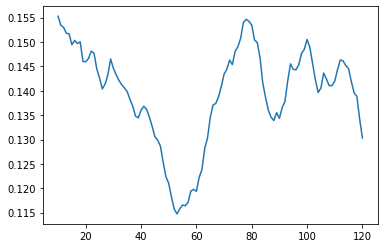

In [265]:
# Single features do not work consistently though
by_era_correlation = pd.Series({
    era: np.corrcoef(tdf["preds_neutralized"], tdf["feature_strength34"])[0,1]
    for era, tdf in df_training.groupby("era")
})
by_era_correlation.plot()
plt.show()
by_era_correlation.rolling(10).mean().plot()

In [23]:
models["LGBMRegressor"].__version__

AttributeError: 'LGBMRegressor' object has no attribute '__version__'